<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/regressao_linear_mortalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
import io
import gzip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import seaborn as sns

In [2]:
idhm = pd.read_excel('https://github.com/mirianbatista/idhm-pb/blob/master/atlas2013_dadosbrutos_pt.xlsx?raw=true', sheet_name=1, dtype = {'UF': str, 'Codmun7':str}) 

In [3]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
cols = 'city','city_ibge_code','date','estimated_population_2019','last_available_death_rate'
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, usecols=cols, parse_dates=["date"], dtype={"city_ibge_code": str})
covid = covid[covid.date == max(covid.date)]
covid

,city,city_ibge_code,date,estimated_population_2019,last_available_death_rate
9802,Acrelândia,1200013,2021-06-25,15256.0,0.0220
9803,Assis Brasil,1200054,2021-06-25,7417.0,0.0138
9804,Brasiléia,1200104,2021-06-25,26278.0,0.0134
9805,Bujari,1200138,2021-06-25,10266.0,0.0150
9806,Capixaba,1200179,2021-06-25,11733.0,0.0261
...,...,...,...,...,...
2309243,Tupirama,1721257,2021-06-25,1891.0,0.0121
2309244,Tupiratins,1721307,2021-06-25,2671.0,0.0190
2309245,Wanderlândia,1722081,2021-06-25,11683.0,0.0170
2309246,Xambioá,1722107,2021-06-25,11540.0,0.0130


In [4]:
idhmcovid = pd.merge(idhm, covid, left_on="Codmun7", right_on="city_ibge_code", how="left") 
idhmcovid = idhmcovid.loc[(idhmcovid['estimated_population_2019'] > 20000) & (idhmcovid['ANO'] == 2010)].dropna()
idhmcovid.head()

,ANO,UF,Codmun6,Codmun7,Município,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,SOBRE40,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_0_FUND,T_ATRASO_0_MED,T_ATRASO_1_BASICO,T_ATRASO_1_FUND,T_ATRASO_1_MED,T_ATRASO_2_BASICO,T_ATRASO_2_FUND,T_ATRASO_2_MED,T_FBBAS,T_FBFUND,T_FBMED,T_FBPRE,T_FBSUPER,T_FLBAS,T_FLFUND,T_FLMED,T_FLPRE,T_FLSUPER,...,peso13,PESO15,peso1517,PESO1524,PESO1618,PESO18,Peso1820,PESO1824,Peso1921,PESO25,peso4,peso5,peso6,PESO610,Peso617,PESO65,PESOM1014,PESOM1517,PESOM15M,PESOM25M,pesoRUR,pesotot,pesourb,PIA,PIA1014,PIA1517,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R,city,city_ibge_code,date,estimated_population_2019,last_available_death_rate
11130,2010,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,47.37,94.50,83.18,5.84,8.67,1.22,1.52,11.99,1.68,13.00,2.72,15.76,57.62,63.21,66.39,20.36,18.97,25.81,22.03,17.82,7.79,90.45,107.69,45.99,35.40,21.23,85.25,92.88,34.60,34.15,10.50,...,1140,17976,1577,4788,1536,16399,1497,3211,1433,13188,399,429,413,2196,5170,1425,1145,747,8605,6284,10422,24392,13970,20434.0,2401.0,1602.0,16431.0,24097,22429,0.368,0.629,0.641,0.526,0.763,0.657,Alta Floresta D'Oeste,1100015,2021-06-25,22945.0,0.0165
11131,2010,11,110002,1100023,ARIQUEMES,73.36,1.91,19.2,20.53,46.68,96.12,87.69,4.36,9.18,1.55,1.09,7.90,1.13,8.53,1.89,10.48,58.43,60.96,72.93,22.22,22.30,23.11,19.35,16.74,3.96,94.78,106.62,58.77,46.92,27.95,85.46,91.31,37.07,40.96,12.91,...,4270,65521,5497,18019,5420,60024,5330,12522,5360,47502,1522,1565,1564,8593,19709,3943,4515,2739,32552,23467,13828,90353,76525,74725.0,9256.0,5256.0,60213.0,89766,88730,0.514,0.648,0.702,0.600,0.806,0.716,Ariquemes,1100023,2021-06-25,107863.0,0.0215
11133,2010,11,110004,1100049,CACOAL,74.27,1.90,14.3,15.38,43.79,96.41,88.56,5.57,9.74,1.01,0.80,8.29,0.93,8.94,1.57,10.95,66.69,71.14,71.07,17.74,16.28,21.60,15.57,12.58,7.33,100.81,108.09,80.94,54.45,38.23,88.24,93.02,43.97,51.33,17.45,...,3455,58893,4729,15592,4770,54164,4617,10863,4634,43301,1180,1218,1216,6454,15675,4378,3708,2333,29758,21922,16653,78574,61921,66376.0,7473.0,4547.0,54356.0,78141,76876,0.488,0.698,0.718,0.620,0.821,0.727,Cacoal,1100049,2021-06-25,85359.0,0.0205
11138,2010,11,110009,1100098,ESPIGÃO D'OESTE,74.15,2.22,15.4,16.47,46.83,96.41,88.54,5.21,9.55,2.17,1.28,11.33,1.11,12.18,2.54,14.87,65.19,70.26,66.35,18.72,17.42,28.68,16.09,12.32,4.97,97.47,106.42,71.24,32.47,18.67,86.99,92.12,38.96,30.29,9.83,...,1392,20934,1639,5407,1617,19295,1647,3768,1645,15527,501,519,459,2492,5866,1496,1399,830,10260,7564,8119,28729,20610,23897.0,2849.0,1653.0,19395.0,28510,27791,0.402,0.619,0.672,0.536,0.819,0.691,Espigão D'Oeste,1100098,2021-06-25,32374.0,0.0186
11139,2010,11,110010,1100106,GUAJARÁ-MIRIM,74.39,2.61,14.8,15.92,56.67,96.53,88.88,4.82,8.17,2.20,1.77,8.06,1.99,8.70,2.78,10.47,48.13,51.27,66.81,25.26,26.82,24.91,26.61,21.91,8.27,96.87,107.88,61.70,43.87,17.32,85.03,91.06,31.72,40.96,5.66,...,2346,27975,2595,7875,2513,25380,2382,5280,2264,20100,814,847,834,4403,9694,2006,2161,1334,13993,10094,6449,41656,35207,33017.0,4602.0,2575.0,25841.0,39928,38203,0.486,0.537,0.657,0.519,0.823,0.663,Guajará-Mirim,1100106,2021-06-25,46174.0,0.0403


In [5]:
correlacao_positiva = idhmcovid.corr().loc['last_available_death_rate'].sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
correlacao_positiva.drop(correlacao_positiva.loc[(correlacao_positiva['indicador'] == "last_available_death_rate")].index, inplace=True)
correlacao_positiva

,indicador,last_available_death_rate
1,T_DES1517,0.240230
2,P_SERV,0.235086
3,T_DES1824,0.211307
4,T_DES1014,0.194236
5,T_DES,0.183132
6,T_DES18M,0.178465
7,T_FUND25M,0.167246
8,P_MED,0.163721
9,P_FUND,0.159737


In [6]:
correlacao_positiva = idhmcovid.corr(method='spearman').loc['last_available_death_rate'].sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
correlacao_positiva.drop(correlacao_positiva.loc[(correlacao_positiva['indicador'] == "last_available_death_rate")].index, inplace=True)
correlacao_positiva

,indicador,last_available_death_rate
1,HOMEM70A74,0.276295
2,HOMEM65A69,0.274757
3,HOMEM60A64,0.270877
4,HOMEM75A79,0.268582
5,MULH65A69,0.261598
6,HOMEM55A59,0.261011
7,T_DES1517,0.260534
8,MULH60A64,0.259250
9,MULH55A59,0.258749


In [7]:
corr_posit = correlacao_positiva.indicador.to_list()
corr_posit

['HOMEM70A74',
 'HOMEM65A69',
 'HOMEM60A64',
 'HOMEM75A79',
 'MULH65A69',
 'HOMEM55A59',
 'T_DES1517',
 'MULH60A64',
 'MULH55A59']

In [8]:
corr_positiva = idhmcovid[idhmcovid.columns.intersection(corr_posit)]
corr_positiva

,T_DES1517,HOMEM55A59,HOMEM60A64,HOMEM65A69,HOMEM70A74,HOMEM75A79,MULH55A59,MULH60A64,MULH65A69
11130,23.16,489,351,301,239,154,431,311,264
11131,15.50,1515,1110,788,607,374,1484,1041,735
11133,17.20,1436,1081,746,612,385,1427,1008,795
11138,11.33,535,413,299,201,147,499,384,282
11139,12.95,624,506,353,276,184,636,526,347
...,...,...,...,...,...,...,...,...,...
16673,14.94,442,336,275,198,145,394,329,262
16680,20.84,1859,1451,1107,811,521,2148,1688,1184
16685,7.07,792,651,482,389,286,810,672,544
16688,46.76,1714,1210,728,500,312,1848,1185,847


In [9]:
mortalidade = idhmcovid.last_available_death_rate

In [10]:
xtrain_corr_positiva, xtest_corr_positiva, ytrain_corr_positiva, ytest_corr_positiva = train_test_split(corr_positiva, mortalidade, test_size=0.4, random_state=42)

In [11]:
linreg_corr_positiva = LinearRegression()
linreg_corr_positiva.fit(xtrain_corr_positiva, ytrain_corr_positiva)
print('linear model coeff (w): {}'
.format(linreg_corr_positiva.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_positiva.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_positiva.score(xtrain_corr_positiva, ytrain_corr_positiva)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_positiva.score(xtest_corr_positiva, ytest_corr_positiva)))

linear model coeff (w): [ 2.86892569e-04 -9.59118376e-07  1.37670061e-05  7.24133357e-06
  1.87356333e-06 -1.71527843e-05 -1.00895903e-05 -4.35460041e-07
  5.67220141e-06]
linear model intercept (b): 0.017
R-squared score (training): 0.113
R-squared score (test): 0.001


In [12]:
ipred_corr_positiva = linreg_corr_positiva.predict(xtest_corr_positiva)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_positiva, ipred_corr_positiva))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_positiva, ipred_corr_positiva))

Mean squared error: 0.00
Coefficient of determination: 0.00


In [13]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_positiva, y=ipred_corr_positiva, mode='markers')) 
fig.update_layout(title="Valores reais e previstos de correlação positiva de mortalidade de COVID-19")
fig.show()

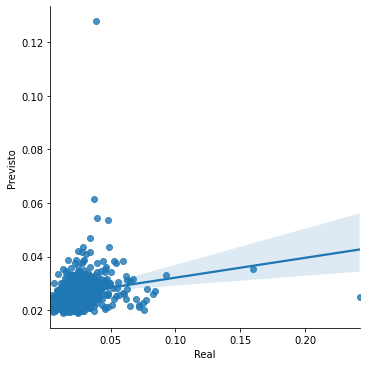

In [14]:
df_corr_positiva = pd.DataFrame ({'Real': ytest_corr_positiva, 'Previsto': ipred_corr_positiva}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_positiva);

In [15]:
correlacao_negativa = idhmcovid.corr().loc['last_available_death_rate'].sort_values().to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
correlacao_negativa

,indicador,last_available_death_rate
0,T_ATIV1517,-0.231833
1,T_ATIV1014,-0.214419
2,P_AGRO,-0.189300
3,THEILtrab,-0.156065
4,T_FUNDIN_TODOS,-0.142199
5,T_CRIFUNDIN_TODOS,-0.141121
6,REN0,-0.135171
7,REN1,-0.132616
8,T_FUNDIN18MINF,-0.129264
9,T_SLUZ,-0.117727


In [16]:
correlacao_negativa = idhmcovid.corr(method='spearman').loc['last_available_death_rate'].sort_values().to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
correlacao_negativa

,indicador,last_available_death_rate
0,T_ATIV1014,-0.270599
1,P_AGRO,-0.246177
2,REN0,-0.242714
3,T_ATIV1517,-0.190833
4,T_SLUZ,-0.176086
5,T_CRIFUNDIN_TODOS,-0.170322
6,T_FUNDIN_TODOS,-0.164937
7,REN1,-0.163958
8,THEILtrab,-0.157473
9,T_FUNDIN18MINF,-0.145453


In [17]:
corr_negat = correlacao_negativa.indicador.to_list()
corr_negativa = idhmcovid[idhmcovid.columns.intersection(corr_negat)]

In [18]:
xtrain_corr_negativa, xtest_corr_negativa, ytrain_corr_negativa, ytest_corr_negativa = train_test_split(corr_negativa, mortalidade, test_size=0.4, random_state=42)

In [19]:
linreg_corr_negativa = LinearRegression()
linreg_corr_negativa.fit(xtrain_corr_negativa, ytrain_corr_negativa)
print('linear model coeff (w): {}'
.format(linreg_corr_negativa.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_negativa.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_negativa.score(xtrain_corr_negativa, ytrain_corr_negativa)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_negativa.score(xtest_corr_negativa, ytest_corr_negativa)))

linear model coeff (w): [-2.13701260e-04  6.37106121e-05  4.80311262e-05  3.04153435e-04
 -5.02487968e-04 -1.71995016e-02 -7.65485458e-04  8.25155907e-04
  4.85813281e-06 -2.17737914e-04]
linear model intercept (b): 0.051
R-squared score (training): 0.135
R-squared score (test): 0.093


In [20]:
ipred_corr_negativa = linreg_corr_negativa.predict(xtest_corr_negativa)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_negativa, ipred_corr_negativa))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_negativa, ipred_corr_negativa))

Mean squared error: 0.00
Coefficient of determination: 0.09


In [21]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_negativa, y=ipred_corr_negativa, mode='markers')) 
fig.update_layout(title="Valores reais e previstos de correlação negativa de mortalidade de COVID-19")
fig.show()

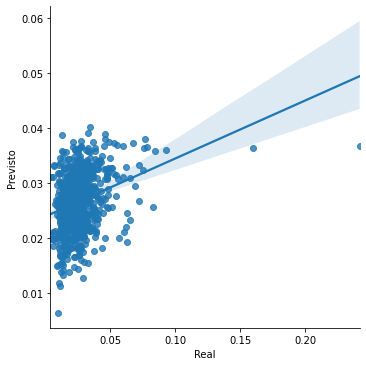

In [22]:
df_corr_negativa = pd.DataFrame ({'Real': ytest_corr_negativa, 'Previsto': ipred_corr_negativa}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_negativa)

In [23]:
idhmcovid_cor_abs = idhmcovid.corr(method='spearman').abs()
correlacao_abs = idhmcovid_cor_abs.loc['last_available_death_rate'].sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[1:101]
correlacao_abs

,indicador,last_available_death_rate
1,HOMEM70A74,0.276295
2,HOMEM65A69,0.274757
3,HOMEM60A64,0.270877
4,T_ATIV1014,0.270599
5,HOMEM75A79,0.268582
...,...,...
96,T_FREQ15A17,0.152744
97,T_DES18M,0.151861
98,RMPOB,0.147391
99,IDHM_E,0.145912


In [24]:
idhmcovid_cor_abs_colin = idhmcovid_cor_abs[correlacao_abs['indicador']].unstack().sort_values(ascending=False).reset_index(name='correlation')
idhmcovid_cor_abs_colin = idhmcovid_cor_abs_colin[idhmcovid_cor_abs_colin.correlation >= 0.8]
idhmcovid_cor_abs_colin = pd.merge(idhmcovid_cor_abs_colin, correlacao_abs, left_on="level_0", right_on="indicador", how="right").rename(columns = {'last_available_death_rate': 'cor_1'}).drop(columns='indicador')
idhmcovid_cor_abs_colin = pd.merge(idhmcovid_cor_abs_colin, correlacao_abs, left_on="level_1", right_on="indicador", how="right").rename(columns = {'last_available_death_rate': 'cor_2'}).drop(columns='indicador')
idhmcovid_cor_abs_colin
idhmcovid_cor_abs_colin = idhmcovid_cor_abs_colin[idhmcovid_cor_abs_colin.cor_1 > idhmcovid_cor_abs_colin.cor_2]
idhmcovid_cor_abs_colin = idhmcovid_cor_abs_colin[idhmcovid_cor_abs_colin.level_0 != idhmcovid_cor_abs_colin.level_1]


In [25]:
# Variáveis que podem sair da regressão por causa da multicolinearidade
# Tem variáveis com forte correlação com elas e que possuem correlação mais forte com mortalidade
import numpy as np
idhmcovid_cor_abs_colin_cols = idhmcovid_cor_abs_colin.level_1.unique()
idhmcovid_cor_abs_colin_cols = np.append(idhmcovid_cor_abs_colin_cols, 'T_SLUZ')
idhmcovid_cor_abs_colin_cols

array(['HOMEM65A69', 'HOMEM60A64', 'HOMEM75A79', 'MULH65A69',
       'HOMEM55A59', 'MULH60A64', 'MULH55A59', 'MULH50A54', 'PESO65',
       'pesourb', 'HOMEM50A54', 'MULH70A74', 'MULH45A49', 'P_AGRO',
       'REN0', 'MULH40A44', 'PESO25', 'HOMEM45A49', 'MULH75A79',
       'MULH35A39', 'PIA18M', 'PESO18', 'HOMEM40A44', 'PESOM25M',
       'PESO15', 'PIA', 'POPT', 'HOMEM35A39', 'HOMENS80', 'pesotot',
       'HOMEMTOT', 'MULHERTOT', 'POP', 'PESOM15M', 'MULH30A34',
       'PESO1214', 'HOMEM30A34', 'estimated_population_2019', 'PESO1114',
       'PESO1113', 'HOMEM10A14', 'peso1517', 'PIA1014', 'MULHER80',
       'HOMEM15A19', 'MULH10A14', 'PIA1517', 'PESO1618', 'Peso617',
       'HOMEM25A29', 'MULH15A19', 'PEA18M', 'PESOM1014', 'PESO1524',
       'PESOM1517', 'Peso1820', 'PESO610', 'HOMEM5A9', 'MULH25A29',
       'HOMEM20A24', 'MULH5A9', 'Peso1921', 'PEA', 'PESO1824', 'peso6',
       'peso5', 'peso4', 'MULH0A4', 'peso13', 'MULH20A24', 'HOMEM0A4',
       'peso1', 'T_AGUA', 'P_FUND', 'P_MED', '

In [26]:
corr_posit_negat = corr_posit + corr_negat
corr_pos_neg = idhmcovid[idhmcovid.columns.intersection(corr_posit_negat)]

In [27]:
corr_pos_neg = idhmcovid[correlacao_abs['indicador']].drop(columns=idhmcovid_cor_abs_colin_cols)
corr_posit_negat = corr_pos_neg.columns
corr_pos_neg

,HOMEM70A74,T_ATIV1014,T_DES1517,P_SERV,T_DES1014,T_ATIV1517,T_DES1824,T_LUZ,THEILtrab,T_FREQ15A17
11130,239,9.08,23.16,33.18,10.51,28.98,10.25,93.98,0.52,79.60
11131,607,7.89,15.50,40.06,11.63,33.66,7.78,98.58,0.44,76.42
11133,612,11.80,17.20,39.07,11.36,41.44,13.10,98.89,0.53,81.04
11138,201,20.64,11.33,31.45,4.05,46.22,10.04,96.70,0.43,75.91
11139,276,4.60,12.95,51.64,3.92,21.20,18.08,97.71,0.41,81.73
...,...,...,...,...,...,...,...,...,...,...
16673,198,12.03,14.94,40.25,0.00,41.64,6.43,99.58,0.47,86.24
16680,811,7.76,20.84,43.11,26.03,37.69,11.22,99.92,0.26,78.61
16685,389,10.90,7.07,41.06,4.63,42.52,9.82,99.76,0.61,83.73
16688,500,5.86,46.76,56.14,27.76,26.61,14.23,99.95,0.33,87.44


In [28]:
xtrain_corr_pos_neg, xtest_corr_pos_neg, ytrain_corr_pos_neg, ytest_corr_pos_neg = train_test_split(corr_pos_neg, mortalidade, test_size=0.4, random_state=42)

In [29]:
linreg_corr_pos_neg = LinearRegression()
linreg_corr_pos_neg.fit(corr_pos_neg, mortalidade)
#linreg_corr_pos_neg.fit(xtrain_corr_pos_neg, ytrain_corr_pos_neg)
print('linear model coeff (w): {}'
.format(linreg_corr_pos_neg.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_pos_neg.intercept_))
print('R-squared score (all data): {:.3f}'
.format(linreg_corr_pos_neg.score(corr_pos_neg, mortalidade)))
print('R-squared score (train): {:.3f}'
.format(linreg_corr_pos_neg.score(xtrain_corr_pos_neg, ytrain_corr_pos_neg)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_pos_neg.score(xtest_corr_pos_neg, ytest_corr_pos_neg)))

linear model coeff (w): [ 4.63314889e-07  2.49382799e-04  4.53754332e-05  1.75981319e-04
  5.64938567e-05 -3.33393627e-04  6.17863723e-05  1.67814545e-04
 -2.19870613e-02  6.99815366e-05]
linear model intercept (b): 0.012
R-squared score (all data): 0.128
R-squared score (train): 0.158
R-squared score (test): 0.086


In [30]:
pd.DataFrame({'variavel': corr_posit_negat, 'coeficiente': linreg_corr_pos_neg.coef_}).sort_values('coeficiente', ascending=False)

,variavel,coeficiente
1,T_ATIV1014,2.493828e-04
3,P_SERV,1.759813e-04
7,T_LUZ,1.678145e-04
9,T_FREQ15A17,6.998154e-05
6,T_DES1824,6.178637e-05
4,T_DES1014,5.649386e-05
2,T_DES1517,4.537543e-05
0,HOMEM70A74,4.633149e-07
5,T_ATIV1517,-3.333936e-04
8,THEILtrab,-2.198706e-02


In [31]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

X = corr_pos_neg
y = mortalidade
model = LinearRegression()

preprocessor = make_column_transformer(
    (StandardScaler(), corr_posit_negat),
    remainder='passthrough'
)

model = make_pipeline(
    preprocessor,
    LinearRegression()
)

_ = model.fit(X, y)

X_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X),
    columns=corr_posit_negat
)

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

coefs = pd.DataFrame(
    [est.named_steps['linearregression'].coef_ * X_preprocessed.std(axis=0) for est in cv_model['estimator']], columns=corr_posit_negat
)


coefs1 = pd.DataFrame(
    [model['linearregression'].coef_ * X_preprocessed.std(axis=0)], columns=corr_posit_negat
)
coefs1

,HOMEM70A74,T_ATIV1014,T_DES1517,P_SERV,T_DES1014,T_ATIV1517,T_DES1824,T_LUZ,THEILtrab,T_FREQ15A17
0,0.00141,0.001292,0.000469,0.001649,0.000724,-0.003309,0.000396,0.000924,-0.002531,0.000379


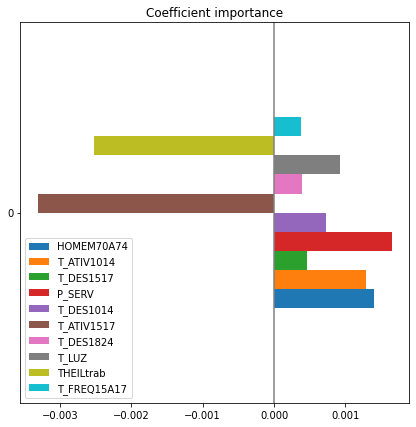

In [32]:
coefs1.plot(kind='barh', figsize=(9, 7))
plt.title('Coefficient importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

**HOMEM70A74**: População masculina de 70 a 74 anos de idade\
**T_ATIV1014**: Taxa de atividade das pessoas de 10 a  14 anos de idade\
**T_DES1517**: Taxa de desocupação da população de 15 a 17 anos de idade\
**P_SERV**: Percentual dos ocupados no setor serviços\
**T_DES1014**: Taxa de desocupação da população de 10 a 14 anos de idade\
**T_ATIV1517**: Taxa de atividade das pessoas de 15 a  17 anos de idade\
**T_DES1824**: Taxa de desocupação da população de 18 a 24 anos de idade\
**T_LUZ**: Percentual da população que vive em domicílios com energia elétrica\
**THEILtrab**: Mede a desigualdade na distribuição de renda\
**T_FREQ15A17**: Taxa de atendimento escolar da população de 15 a 17 anos de idade \
\
descrição de todas as variáveis do IDHM: https://docs.google.com/spreadsheets/d/1CBN0-0Og-hRN-ovSAEbobgzhUxTZt3CoVsq1YMXpss4/edit?usp=sharing

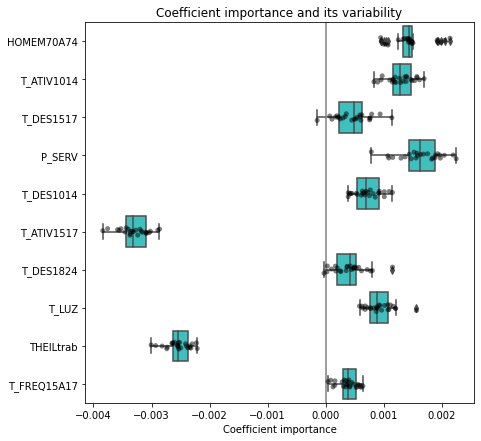

In [33]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

In [34]:
pred_corr_pos_neg = model.predict(X)
print('Mean squared error: %.2f'
      % mean_squared_error(y, pred_corr_pos_neg))
print('Coefficient of determination: %.2f'
      % r2_score(y, pred_corr_pos_neg))

Mean squared error: 0.00
Coefficient of determination: 0.13


In [35]:
pred_corr_pos_neg = linreg_corr_pos_neg.predict(xtest_corr_pos_neg)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_pos_neg, pred_corr_pos_neg))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_pos_neg, pred_corr_pos_neg))

Mean squared error: 0.00
Coefficient of determination: 0.09


In [36]:
idhmcovid_cor_abs['T_LUZ'].sort_values()

T_FLFUND    0.006834
peso5       0.012235
HOMEM5A9    0.012591
peso6       0.013477
MULH5A9     0.015080
              ...   
PIND        0.815893
RDPC1       0.818364
T_LUZ       1.000000
T_SLUZ      1.000000
ANO              NaN
Name: T_LUZ, Length: 236, dtype: float64

In [37]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_pos_neg, y=pred_corr_pos_neg, mode='markers')) 
fig.update_layout(title="Valores reais e previstos das 20 maiores correlações de mortalidade de COVID-19")
fig.show()

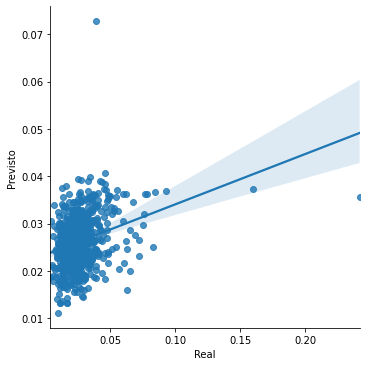

In [38]:
df_corr_pos_neg = pd.DataFrame ({'Real': ytest_corr_pos_neg, 'Previsto': pred_corr_pos_neg}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_pos_neg)